# Dimension Reduction Method

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_decomposition import PLSRegression

In [80]:
# import data
X_train = pd.read_csv('data/X_train.csv')
X_val = pd.read_csv('data/X_val.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_val = pd.read_csv('data/y_val.csv')
y_test = pd.read_csv('data/y_test.csv')

## Principal Component Regression

PCA reduces the number of dimensions in large datasets to principal components that retain most of the original information. PCA tries to explain X best. 

In [81]:
# Apply PCA
pca = PCA()  
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

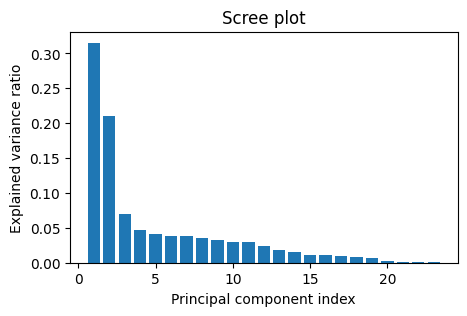

In [82]:
# Scree plot
plt.figure(figsize=(5, 3))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot')
plt.show()

An elbow is seen after the first two principal components.

In [83]:
# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_[:2])

Explained variance ratio: [0.31536077 0.20972532]


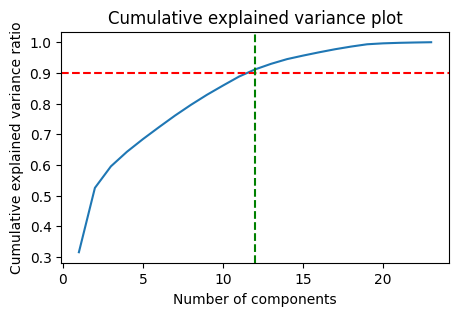

In [84]:
# plot cumulative explained variance
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Cumulative explained variance plot')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axvline(x=12, color='g', linestyle='--')
plt.show()

The first 12 components explain 90% of the variance. 

### Visualization

Text(0.5, 1.0, 'PCA of training data')

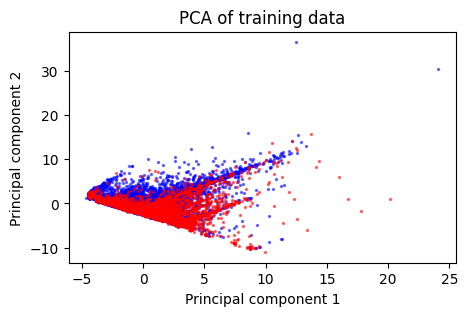

In [85]:
a = y_train.iloc[:,0].values

# Plot the PCA results
plt.figure(figsize=(5, 3))
plt.scatter(X_train_pca[a == 0, 0], X_train_pca[a == 0, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X_train_pca[a == 1, 0], X_train_pca[a == 1, 1], color='red', alpha=0.5, s=2)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PCA of training data')

### Baseline

In [86]:
# perform logistic regression with PCA on validation set
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg.fit(X_train_pca, a)
y_pred_baseline = log_reg.predict(X_val_pca)
print("Logistic Regression classification report:\n", classification_report(y_val.iloc[:,0].values, y_pred_baseline))
# Confusion matrix
cm_baseline = confusion_matrix(y_val.iloc[:,0].values, y_pred_baseline)

Logistic Regression classification report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78      4673
           1       0.37      0.61      0.46      1327

    accuracy                           0.69      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.69      0.71      6000



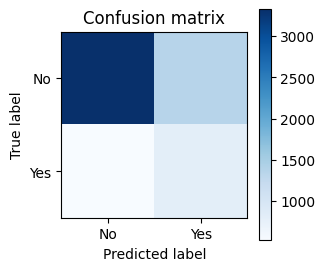

In [87]:
plt.figure(figsize=(3, 3))
plt.imshow(cm_baseline, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No', 'Yes'])
plt.yticks(np.arange(2), ['No', 'Yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Cross-validation to determine optimal number of components

In predicting credit default, false negatives (failing to predict an actual default) are more costly than false positives. Since standard accuracy metrics don't account for the asymmetric costs, we'll:
- Create a custom scoring function that heavily penalizes false negatives
- Use class weights to make the model more sensitive to defaults
- Consider precision-recall metrics that focus on the positive class

In [88]:
def fn_penalized_score(y_true, y_pred, fn_cost=5, fp_cost=1):
    """Custom score that heavily penalizes false negatives"""
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # False negatives
    fp = cm[0, 1]  # False positives
    total_cost = fn * fn_cost + fp * fp_cost
    return -total_cost  # Return negative for GridSearchCV maximization

custom_scorer = make_scorer(fn_penalized_score, greater_is_better=False)

# Create imbalanced pipeline with SMOTE -> PCA -> Logistic Regression
pipeline = make_pipeline(
    SMOTE(random_state=42),  # Handle class imbalance
    PCA(),                   # Principal Component Analysis
    LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
)

# Parameter grid for GridSearch
param_grid = {
    'pca__n_components': [2, 5, 8, 11, 14],  # Number of principal components
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],  # Regularization
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']  # solvers for l1 and l2
}

# Stratified KFold maintains class balance in splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with custom scoring
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=skf,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_pca, y_train.iloc[:,0].values)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'pca__n_components': [2, 5, 8, 11, 14]},
             scoring=make_scorer(fn_penalized_score, greater_is_better=False, response_method='predict'),
             verbose=1)

In [89]:
# Get results
cv_results = grid.cv_results_
best_model = grid.best_estimator_
best_n_components = grid.best_params_['pca__n_components']

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)
print("Best model:", best_model)
print("Best number of components:", best_n_components)

Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga', 'pca__n_components': 2}
Best cross-validation score: 2455.8
Best model: Pipeline(steps=[('smote', SMOTE(random_state=42)), ('pca', PCA(n_components=2)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='saga'))])
Best number of components: 2


In [90]:
# Get predicted probabilities for threshold adjustment
y_proba = cross_val_predict(
    best_model[2],
    X_train_pca[:,:best_n_components],
    y_train.iloc[:, 0].values,
    cv=skf,
    method='predict_proba',
    n_jobs=-1
)[:, 1]  # Probabilities for class 1 (default)

# Find optimal threshold that minimizes our cost function
thresholds = np.linspace(0.1, 0.5, 50)
costs = []

for thresh in thresholds:
    preds = (y_proba > thresh).astype(int)
    cost = fn_penalized_score(y_train.iloc[:,0].values, preds)
    costs.append(cost)
    # print(thresh, cost)

optimal_threshold = thresholds[np.argmax(costs)]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.5


In [91]:
log_cv = best_model[2]
log_cv.fit(X_train_pca[:,:best_n_components], a)
y_pred_cv_proba = log_cv.predict_proba(X_val_pca[:,:best_n_components])
y_pred_cv = (y_pred_cv_proba[:, 1] > optimal_threshold).astype(int)
print("Validation set classification report:\n", classification_report(y_val.iloc[:,0].values, y_pred_cv))

Validation set classification report:
               precision    recall  f1-score   support

           0       0.85      0.64      0.73      4673
           1       0.32      0.61      0.42      1327

    accuracy                           0.63      6000
   macro avg       0.59      0.62      0.57      6000
weighted avg       0.73      0.63      0.66      6000



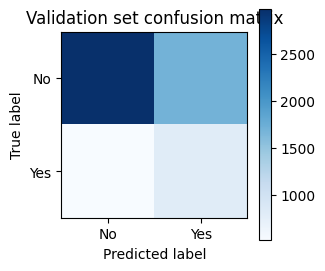

In [92]:
# Confusion matrix for validation set
cm_cv = confusion_matrix(y_val.iloc[:,0].values, y_pred_cv)
plt.figure(figsize=(3, 3))
plt.imshow(cm_cv, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation set confusion matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No', 'Yes'])
plt.yticks(np.arange(2), ['No', 'Yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

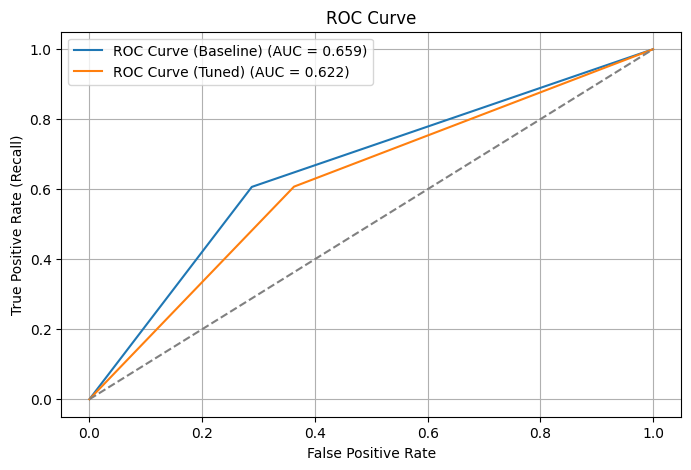

In [93]:
# Compute ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_val.iloc[:,0].values, y_pred_baseline)
auc_score_baseline = roc_auc_score(y_val.iloc[:,0].values, y_pred_baseline)

fpr_cv, tpr_cv, _ = roc_curve(y_val.iloc[:,0].values, y_pred_cv)
auc_score_cv = roc_auc_score(y_val.iloc[:,0].values, y_pred_cv)

# Plot ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr_baseline, tpr_baseline, label=f"ROC Curve (Baseline) (AUC = {auc_score_baseline:.3f})")
plt.plot(fpr_cv, tpr_cv, label=f"ROC Curve (Tuned) (AUC = {auc_score_cv:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## Partial least squares regression

PLS regression is generalizes and combines features from principal component analysis and multiple regression.

In [94]:
# Apply Partial Least Squares (PLS)
pls = PLSRegression()
X_pls = pls.fit_transform(X_scaled, y)[0]

NameError: name 'X_scaled' is not defined

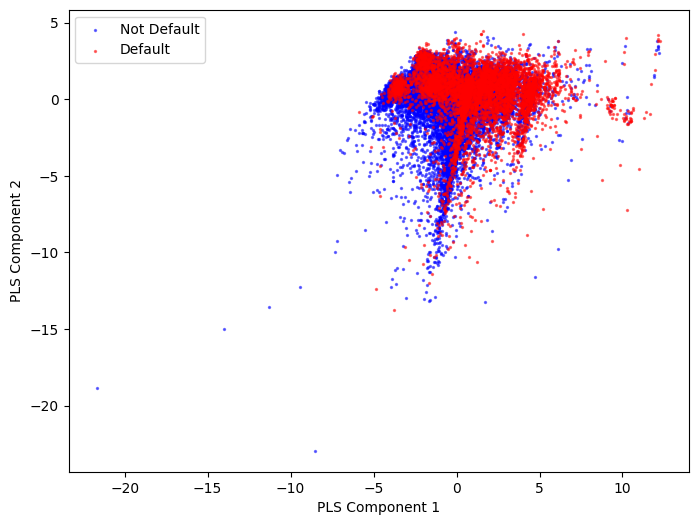

In [ ]:
# Plot the PLS results
plt.figure(figsize=(8, 6))
plt.scatter(X_pls[y == 0, 0], X_pls[y == 0, 1], color='blue', label='Not Default', alpha=0.5, s=2)
plt.scatter(X_pls[y == 1, 0], X_pls[y == 1, 1], color='red', label='Default', alpha=0.5, s=2)
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, average_precision_score